# Convolutional Neural Networks using Tensorflow Estimators to also later demonstrate training on ML Engine

Assumed Knowlegde:
(insert links in case that knowledge isn't there)

This tutorial is an introduction to Convolutional Neural Networks(CNNs) using tensorflow and trained on Google ML Engine. Firstly, I will give a brief introduction of CNNs, best use cases then we will get our hands dirty with some code. 

For this tutorial, we are going to use the fashion MNIST dataset and classify the different clothing types. 

Basics and Types of Layers:
Convolutional Layers
Each layer of the network consists of filter maps. Each filter detects certain features in the image. Each filter slides over the image and uncovers different features. 

Pooling Layers
This layer decreases the dimensionality of the image inorder to increase the performance of the network and also reduce over-fitting. The pooling layer always comes after the convolutional layers.

Fully-connected layer
This layer has all nodes connected to the nodes in the previous layer. This is a classification layer which receives the features extracted by the convolutional and the pooling layers.

Tensorflow provides some great functions to perform all necessary operations so you only have to worry about the performance of the model. 


For this tutorial we will use the Fashion-MNIST dataset, Tensorflow doesn't have a way to download it as yet so we will have to download it inorder to use it. I have downloaded the dataset to my local machine. (insert link). The structure of the dataset is the same as the original MNIST dataset. Image sizes, test and train splits are the same. We are going to use the tensorflow estimators to demonstrate in this case.

In [1]:
 #load data using tensorflow.input
#from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__) 

/Users/tsitsimarote/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


1.13.1


In [2]:
#loss function
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
# Load training and eval data
train_images = train_images/np.float32(255)
train_labels = train_labels.astype(np.int32)  # not required
#train_labels = np.asarray(train_labels).astype('float32').reshape((-1,1))
test_images = test_images/np.float32(255)
test_labels = test_labels.astype(np.int32)
#test_labels = np.asarray(test_labels).astype('float32').reshape((-1,1))
# not required

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


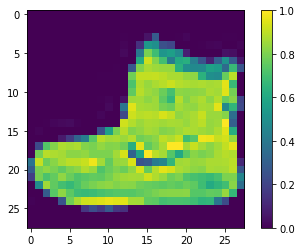

In [6]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [7]:
#train_images = train_images.astype('float32') / 255.0
#test_images = test_images.astype('float32') / 255.0

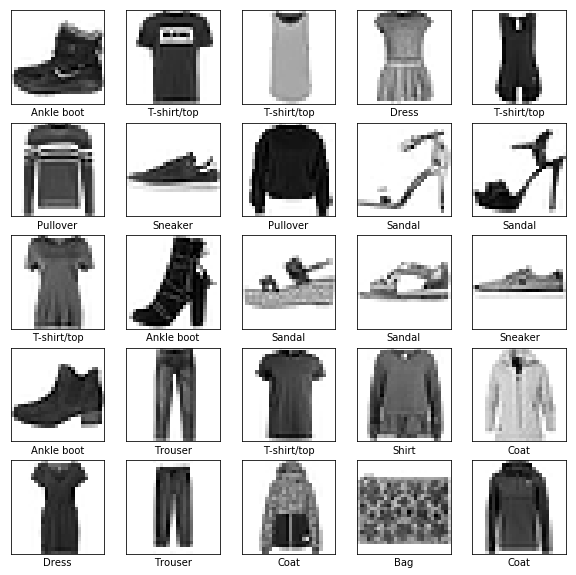

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [9]:
#eval_metric_ops
#This is the evaluation metric that will be used to determine how well the model is performing. The metric to be used is the accuracy
def metric_fn(labels, predictions):
    metrics={}
    indices = parse_label_column(labels)
    pred_class=predictions['class_ids']
    metrics['accuracy'] = tf.metrics.accuracy(labels=indices,
                                                                   predictions=pred_class,
                                                                   num_classes=len(metadata.TARGET_LABELS)
                                                                 )
    return metrics

In [10]:
def cnn_estimator(features, labels, mode):
    #Convolutional layer, takes in the input layer
    #inputs = tf.cast(tf.reshape(features["x"], [-1, 28, 28, 1]), tf.float32)
    #inputs = np.reshape(np.array(features["x"]), [-1, 28, 28, 1])
    #X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    #inputs = np.array(features["x"]).reshape(-1,28,28,1)
    inputs = tf.reshape(features["x"], [-1,28,28,1])
    #y = tf.placeholder(tf.float32, [None, 10])
    #function conv2d that performs our convolution takes in the following inputs:
    #inputs: the first convolutional layer takes in the actual input, the following 
    #convolutional layers take in the output of the preceding layer which is normally the pooling layer 
    #filters: 
    #kernel_size:
    #padding: 'same' means the output shall be padded so that it remains same size as input
    #activation_size
    convolutional_layer1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[5,5], padding='same', activation=tf.nn.relu)
    #Pooling performs subsampling, inorder to reduce dimensionality with a choice of using either max subsampling or average subsampling
    #while we slide over the regions we either pick the max or average of the region depending on our method of method
    #pool size:
    #strides: This determines 
    #Pooling layer, takes in input from the first convolutional layer
    pooling_layer1 = tf.layers.max_pooling2d(inputs=convolutional_layer1, pool_size=[2,2], strides=2)

    #Convolutional layer
    convolutional_layer2 = tf.layers.conv2d(inputs=pooling_layer1, filters=64, kernel_size=[5,5], padding='same', activation=tf.nn.relu)
    
    #Pooling layer
    pooling_layer2 = tf.layers.max_pooling2d(inputs=convolutional_layer2, pool_size=[2,2], strides=2)
    
    #Dense layer
    #print(pooling_layer2.size)
    #flatten = np.reshape(np.array(pooling_layer2), [-1, 7 * 7 * 64])
    #flatten = np.array(pooling_layer2).reshape(-1, 7*7*64)
    flatten = tf.reshape(pooling_layer2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=flatten, units=1024, activation=tf.nn.relu)
    
    #Dropouts
    dropout_layer = tf.layers.dropout(inputs=dense, rate=0.4, training=mode==tf.estimator.ModeKeys.TRAIN)
    logits_layer = tf.layers.dense(inputs=dropout_layer, units=10)
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits_layer, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits_layer, name="softmax_tensor")
  }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits_layer)

  # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [11]:
def classifier(model, model_dir):
    return tf.estimator.Estimator(model_fn=model, model_dir=model_dir)

In [12]:
classifier(cnn_estimator, model_dir="./model_dir")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb4165f358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [14]:
# Train the model
#y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_images},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
classifier(cnn_estimator, model_dir="./model_dir").train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb41681588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` mo

INFO:tensorflow:loss = 1.4119567, step = 2003
INFO:tensorflow:Saving checkpoints for 2003 into ./model_dir/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Loss for final step: 1.4119567.


In [15]:
classifier(cnn_estimator, model_dir="./model_dir").train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb416811d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finali

In [16]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_images},
    y = test_labels,
    num_epochs=1,
    shuffle=False)

eval_results = classifier(cnn_estimator, model_dir="./model_dir").evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model_dir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb41759470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-26T15:04:10Z
INFO:tensorflow:

In [18]:
!pip install -q tensorflow tensorflow-datasets matplotlib

In [19]:
import tensorflow_datasets as tfds


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [20]:
from tensorflow.examples.tutorials.mnist import input_data
fashion = input_data.read_data_sets("./fashionmnist/", one_hot = True) 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


W0626 17:46:55.844623 4540286400 deprecation.py:323] From <ipython-input-20-4e4724097486>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please write your own downloading logic.


W0626 17:46:55.846232 4540286400 deprecation.py:323] From /Users/tsitsimarote/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.


Instructions for updating:
Please use urllib or similar directly.


W0626 17:46:55.849251 4540286400 deprecation.py:323] From /Users/tsitsimarote/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please use urllib or similar directly.


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.


W0626 17:46:56.788346 4540286400 deprecation.py:323] From /Users/tsitsimarote/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting ./fashionmnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.


W0626 17:46:57.477868 4540286400 deprecation.py:323] From /Users/tsitsimarote/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting ./fashionmnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.


W0626 17:46:57.485050 4540286400 deprecation.py:323] From /Users/tsitsimarote/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./fashionmnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./fashionmnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


W0626 17:46:58.290657 4540286400 deprecation.py:323] From /Users/tsitsimarote/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [25]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels

with open('./fashionmnist/train-images-idx3-ubyte.gz', 'rb') as f:
    train_images = extract_images(f)
with open('./fashionmnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_labels = extract_labels(f)

with open('./fashionmnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    test_images = extract_images(f)
with open('./fashionmnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    test_labels = extract_labels(f)

Extracting ./fashionmnist/train-images-idx3-ubyte.gz
Extracting ./fashionmnist/train-labels-idx1-ubyte.gz
Extracting ./fashionmnist/t10k-images-idx3-ubyte.gz
Extracting ./fashionmnist/t10k-labels-idx1-ubyte.gz


In [27]:
train_images.shape

(60000, 28, 28, 1)

In [28]:
train_labels.shape

(60000,)